<style>

h1 {
    color: #fff;
    text-align: center;
    font-size: 80px;
    margin-bottom: 40px;
    margin-top: 60px;
}


p {
    color:#fff;
    font-size: 24px;
    text-align: center;
    margin-bottom: 10px;
}

.details {
    border: 2px solid #fff;
    padding: 20px;
    border-radius: 60px;
    margin: auto;
    max-width: 600px;
    margin-bottom: 30px;
}
</style>

<h1>Customer Churn</h1>

<div class="details">
    <p><strong>Integrantes:</strong> Brayan Garzón, Kevin Güiza, Julian Páez</p>
    <p><strong>Curso:</strong> Machine Learning UIFCE</p>
    <p><strong>Fecha:</strong> Julio de 2023</p>
</div>

# Modelo para Customer Churn

In [1]:
# Importar paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys

sys.path.append("..")
from utility import plot_settings


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine Learning
## Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Entrenamiento
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Evaluación
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, balanced_accuracy_score)


In [3]:
# Carga de datos
data = pd.read_csv('../data/Customer_Churn.csv', sep=';')

In [4]:
# Eliminamos la variable que no aporta información relevante (identificador de cliente)
df = data.copy()
df.drop(columns='CustomerID', inplace=True)

In [5]:
data = data.dropna()

In [6]:
data.shape

(440832, 11)

## 1. Preprocesamiento

- **Tipo de datos de cada variable:**
    - Float64: Age, Usage Frequency, Support Calls, Payment Delay, Total Spend, Last Interaction, Churn.
    - Object: Gender, Subscription Type, Contract Length.

  Podría considerarse la posibilidad de tratar a Support Calls como una variable categórica. Sin embargo, esto generaría al menos 9 variables nuevas, y podría considerarse que esto afecta la parsimonía del modelo. Así, la única variable numérica en realidad categórica es la variable objetivo (que ya está codificada)

### 1.1. Estandarización

In [7]:
numeric_cols = ['Age','Usage Frequency','Support Calls','Payment Delay','Total Spend', 'Last Interaction']

data_num = data[numeric_cols]
data_num.shape

(440832, 6)

In [8]:
# Crear instancia StandardScaler
scaler = StandardScaler()

# Estandarizar las variables
X_scaled = scaler.fit_transform(data_num)

# Dimensiones de los datos estandarizados
X_scaled.shape

(440832, 6)

La conservación de las dimensiones nos demuestra que el proceso de escalamiento no afectó la dimensión del dataset. Para tal proceso se utilizó el standard scaler [¿este escalador es el más apropiado para los datos?]

### 1.2. Codificación

In [9]:
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']

data_cat = data[cat_cols]
data_cat.shape

(440832, 3)

In [10]:
# Codificación
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(data_cat)

# Cantidad de características generadas
X_encoded.shape

(440832, 5)

In [11]:
# Características categóricas codificadas
encoder.get_feature_names_out()

array(['Gender_Male', 'Subscription Type_Premium',
       'Subscription Type_Standard', 'Contract Length_Monthly',
       'Contract Length_Quarterly'], dtype=object)

El codificador generó 2 categorías adicionales para tipo de suscripción y duración de contrato.

### 1.3. Concatenación

In [12]:
# Características a modelar
X = np.concatenate((X_scaled, X_encoded), axis=1)
X.shape

(440832, 11)

In [13]:
# Conservar nombres de las características
feature_names = numeric_cols\
                + encoder.get_feature_names_out()\
                         .tolist()

### 1.4. Serie objetivo

In [14]:
encoder_y = OneHotEncoder(sparse_output=False, drop='if_binary')
y = encoder_y.fit_transform(data['Churn'].values.reshape(-1, 1))

y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

### 1.5. Partición

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=31415)

### 1.6. Balanceo

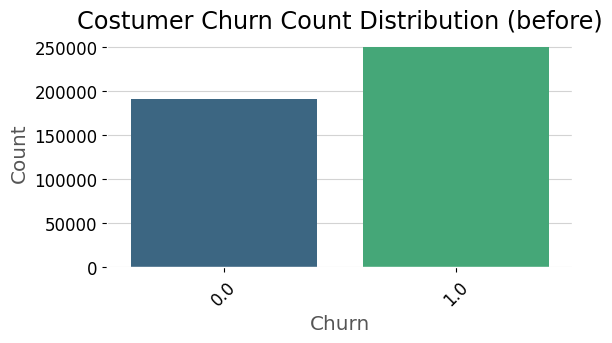

In [16]:
# Graficar antes
plt.figure(figsize=(6, 3))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.title('Costumer Churn Count Distribution (before)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [17]:
# Balanceo con sobremuestreo SMOTE
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train)

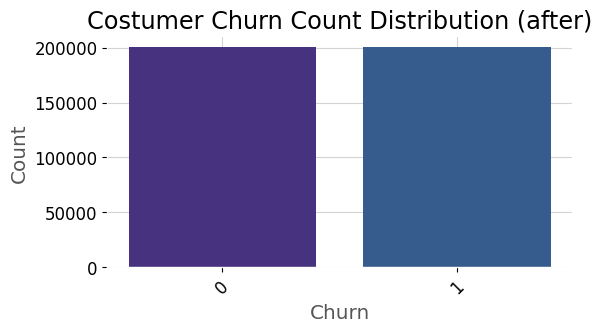

In [18]:
# Graficar luego
class_counts = pd.Series(y_train_balance).value_counts()

plt.figure(figsize=(6, 3))
plt.bar(class_counts.index, class_counts, color=sns.color_palette('viridis'))
plt.xticks(range(2))
plt.title('Costumer Churn Count Distribution (after)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 2. Entrenamiento

### 2.1. Algoritmos a utilizar
1. XGBoostClassifier
2. RandomForest
3. LightGM

### 2.2. Búsqueda de parámetros y validación cruzada
¿Por qué decidió usar la técnica que escogió?

Se propone generar un análisis comparativo utilizando diferentes modelos, tales como: 
- XGBoost (Modelo avanzado que utiliza el método de aumento de gradiente para mejorar la precisión en tareas de clasificación),
- Random Forest (Es un conjunto de árboles de decisión que trabajan juntos para mejorar la precisión en la clasificación) 
- LightGM (Es una implementación eficiente de gradient boosting que se enfoca en la velocidad y el uso eficiente de memoria. )

El objetivo de este análisis es determinar cuál de estos modelos logra predecir de manera más efectiva y precisa. Se considerará su desempeño en la tarea de identificar el comportamiento de churn en un conjunto de datos dado. Cada uno de estos modelos tiene sus propias características y ventajas, por lo que es importante evaluar su rendimiento en relación con los datos y los objetivos específicos del proyecto.

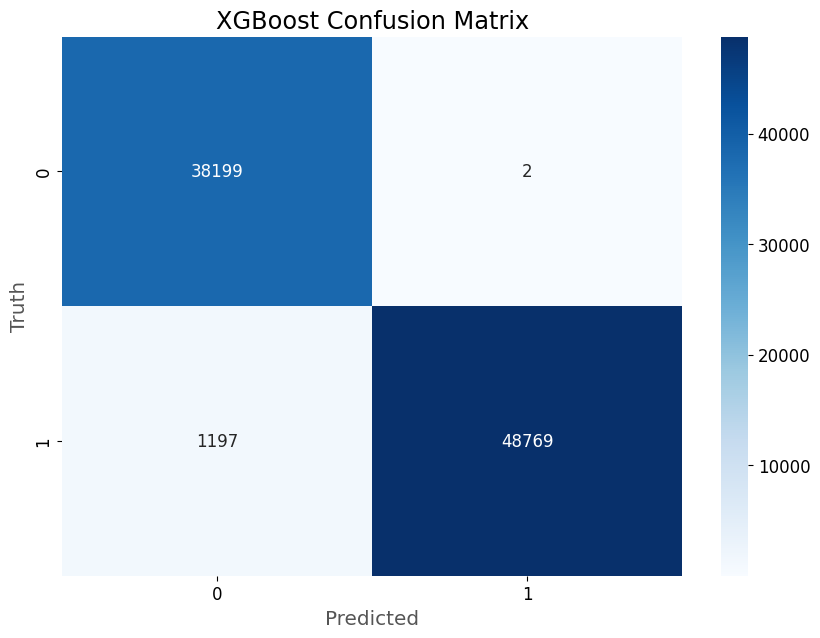

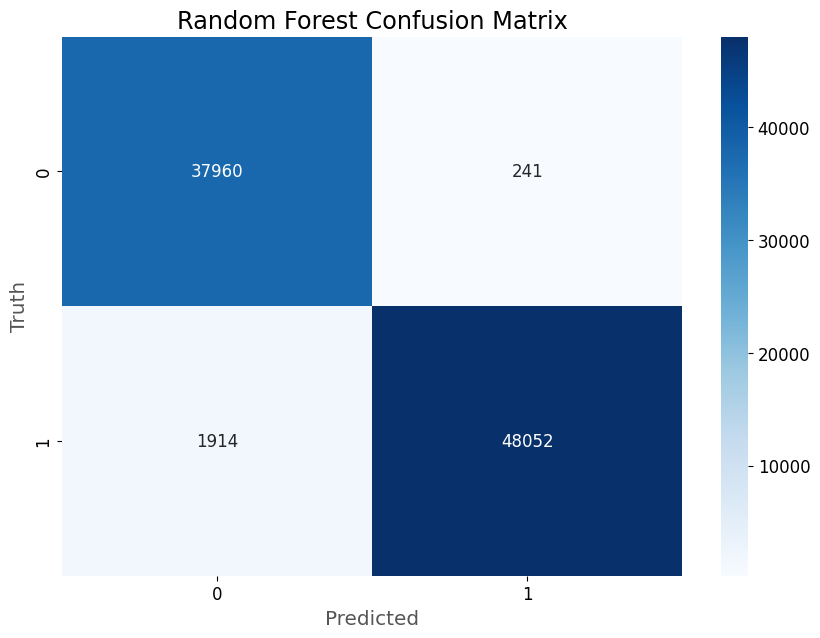

[LightGBM] [Info] Number of positive: 200033, number of negative: 152632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567204 -> initscore=0.270453
[LightGBM] [Info] Start training from score 0.270453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

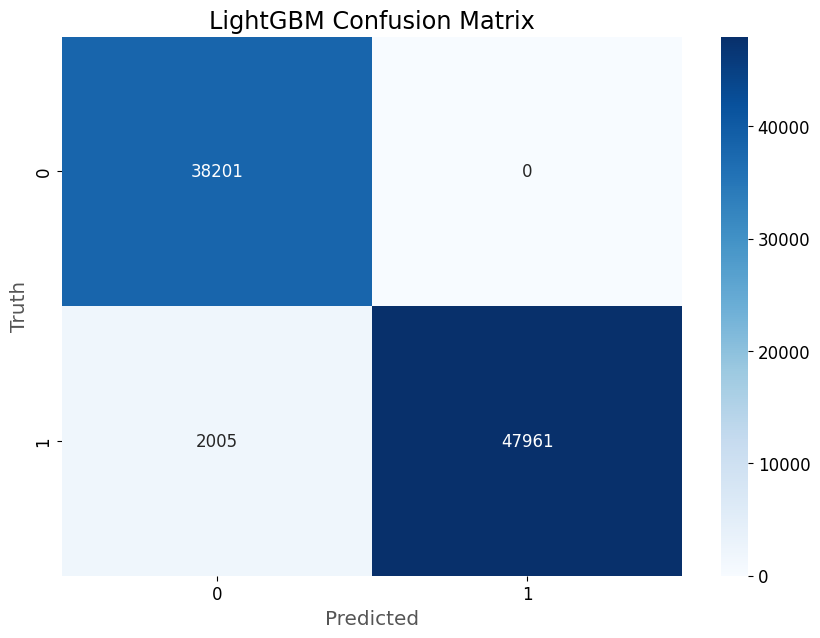

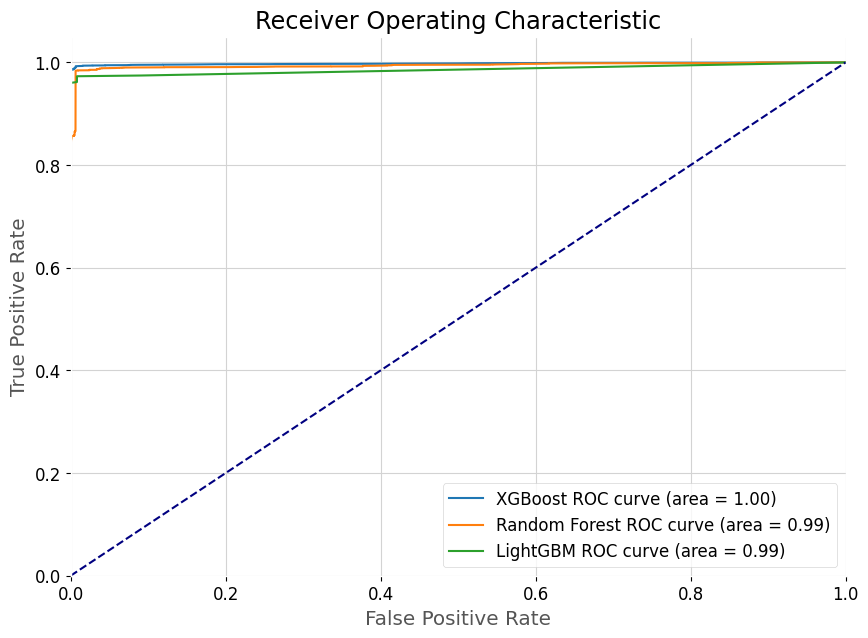

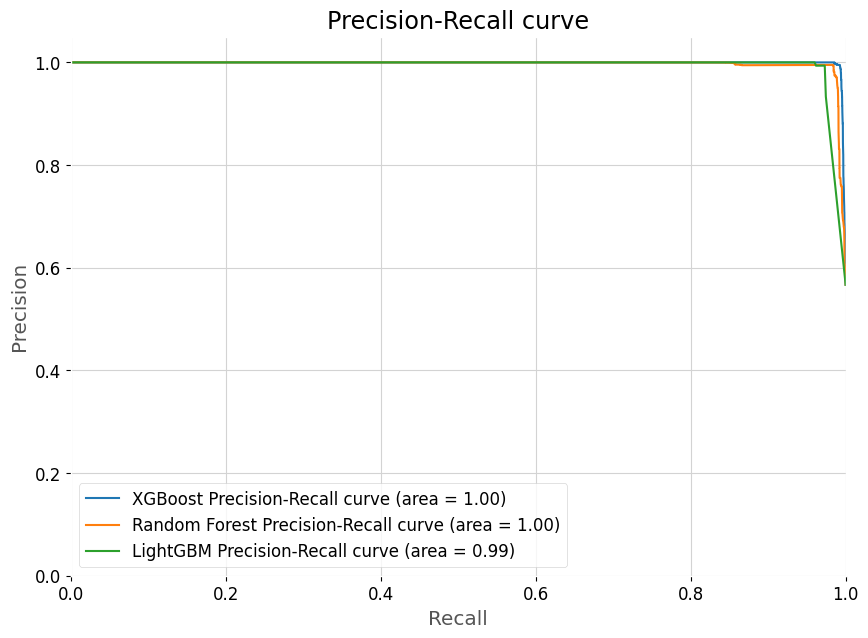

In [26]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Define classifiers
classifiers = {
    "XGBoost": XGBClassifier(
        learning_rate=0.01,
        colsample_bytree=0.4,
        subsample=0.8,
        objective="binary:logistic",
        n_estimators=1000,
        reg_alpha=0.3,
        max_depth=4,
        gamma=10,
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=1000,
        max_depth=4,
    ),
    "LightGBM": lgb.LGBMClassifier(
        learning_rate=0.01,
        n_estimators=100,
        max_depth=4,    
    ),
}


roc_data = []

# Fit, predict and compute ROC curve for each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Save ROC data
    roc_data.append((fpr, tpr, roc_auc, name))

    # Get the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title(f"{name} Confusion Matrix")
    plt.show()


# Initialize the plot for the ROC curve
plt.figure(figsize=(10, 7))

# Plot ROC curve for each classifier
for fpr, tpr, roc_auc, name in roc_data:
    plt.plot(fpr, tpr, label="%s ROC curve (area = %0.2f)" % (name, roc_auc))

# Finalize the plot for the ROC curve
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10, 7))

# Compute Precision-Recall and plot curve for each classifier
for name, clf in classifiers.items():
    y_score = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.plot(
        recall,
        precision,
        label="%s Precision-Recall curve (area = %0.2f)" % (name, average_precision),
    )

# Set labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.legend(loc="lower left")

plt.show()

## 4. Interpretación de resultados

En este proyecto, se abordó el desafío de predecir el customer churn, es decir, identificar a los clientes que podrían dejar de utilizar un servicio o producto. Para ello, se emplearon tres técnicas de aprendizaje automático: XGBoost, Random Forest y LightGBM. El objetivo era determinar cuál de estos modelos ofrece el mejor rendimiento en términos de precisión de predicción y capacidad de generalización.

En este caso los tres modelos, XGBoost, Random Forest y LightGBM, mostraron un excelente rendimiento en la predicción del customer churn. Todos ellos demostraron ser capaces de predecir perfectamente todos los casos.

### Interpretación de las Matrices de Confusión y el Área bajo la Curva (AUC-ROC):

Las matrices de confusión que nos ayudan para evaluar el rendimiento de los modelos de clasificación, en este caso muestra que esta prediciendo la tasa de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos de una manera muy acertada

El Área bajo la Curva (AUC) de la Curva ROC es una métrica comúnmente utilizada para evaluar la habilidad discriminativa de un modelo de clasificación. Cuanto mayor sea el valor del AUC, mejor será la capacidad del modelo para distinguir entre clases, en este caso las curvas ocupan toda el area.

### Elección del Mejor Modelo:

Dado que los tres modelos lograron predecir perfectamente todos los casos de customer churn, la elección del mejor modelo se basará en otros factores como la eficiencia computacional y la escalabilidad. En este caso, se eligió XGBoost debido a amplia adopción en la industria.

En resumen, este proyecto logró su objetivo de predecir el customer churn utilizando técnicas de aprendizaje automático avanzado. Los modelos XGBoost, Random Forest y LightGBM demostraron ser altamente efectivos en esta tarea, y aunque todos obtuvieron resultados certeros en este conjunto de datos.